# Linear regression using gradient descent

Let's import some libraries we will need.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jax.example_libraries import optimizers
from pymatviz.parity import density_scatter
from rdkit import Chem
from tqdm import tqdm

## Download a dataset

In [3]:
soldata = pd.read_csv(
    "https://raw.githubusercontent.com/whitead/dmol-book/main/data/curated-solubility-dataset.csv"
)
features_start_at = list(soldata.columns).index("MolWt")
feature_names = soldata.columns[features_start_at:]

In [4]:
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


In [5]:
soldata[feature_names]

,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,392.510,3.95810,102.4454,23.0,0.0,0.0,2.0,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,169.183,2.40550,51.9012,13.0,1.0,1.0,2.0,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,140.569,2.15250,36.8395,9.0,1.0,0.0,2.0,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,756.226,8.11610,200.7106,53.0,6.0,2.0,7.0,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,422.525,2.48540,119.0760,31.0,6.0,0.0,6.0,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,264.369,2.61700,78.6762,19.0,4.0,1.0,4.0,8.0,106.0,1.0,0.0,0.0,1.0,41.57,115.300645,2.394548e+00,374.236893
9978,444.440,-0.21440,109.5409,32.0,9.0,6.0,10.0,2.0,170.0,1.0,0.0,3.0,4.0,181.62,182.429237,2.047922e+00,1148.584975
9979,150.221,2.82402,46.9328,11.0,1.0,1.0,1.0,1.0,60.0,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720e+00,251.049732
9980,454.611,5.09308,131.6560,33.0,6.0,0.0,6.0,13.0,180.0,2.0,0.0,0.0,2.0,63.95,198.569223,2.023333e+00,938.203977


In [6]:
soldata['Solubility']

0      -3.616127
1      -3.254767
2      -2.177078
3      -3.924409
4      -4.662065
          ...   
9977   -3.010000
9978   -2.930000
9979   -2.190000
9980   -3.980000
9981   -4.780000
Name: Solubility, Length: 9982, dtype: float64

## Explore data

In [7]:
mol = Chem.MolFromSmiles(soldata.iloc[0]['SMILES'])

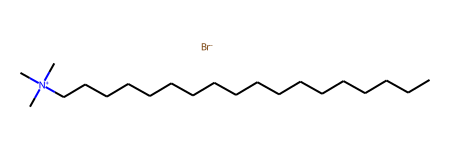

In [8]:
mol

## Build train / test set 

In [9]:
len(soldata)

9982

(array([  2.,   0.,   0.,   2.,   0.,   4.,   0.,   1.,   3.,   3.,  10.,
         12.,  20.,  37.,  45.,  68.,  90., 110., 122., 148., 155., 140.,
        119., 143., 181., 223., 259., 294., 340., 362., 397., 405., 489.,
        494., 597., 566., 527., 564., 511., 444., 399., 340., 293., 245.,
        284., 255., 224.,  39.,  13.,   3.]),
 array([-1.31719000e+01, -1.28657084e+01, -1.25595167e+01, -1.22533251e+01,
        -1.19471335e+01, -1.16409418e+01, -1.13347502e+01, -1.10285586e+01,
        -1.07223669e+01, -1.04161753e+01, -1.01099837e+01, -9.80379204e+00,
        -9.49760041e+00, -9.19140878e+00, -8.88521715e+00, -8.57902551e+00,
        -8.27283388e+00, -7.96664225e+00, -7.66045062e+00, -7.35425898e+00,
        -7.04806735e+00, -6.74187572e+00, -6.43568409e+00, -6.12949245e+00,
        -5.82330082e+00, -5.51710919e+00, -5.21091756e+00, -4.90472593e+00,
        -4.59853429e+00, -4.29234266e+00, -3.98615103e+00, -3.67995940e+00,
        -3.37376776e+00, -3.06757613e+00, -2.76138

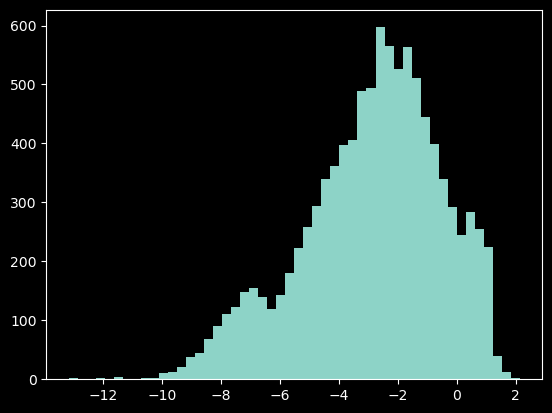

In [10]:
plt.hist(soldata['Solubility'], bins=50)

Note that this kind of random splitting is not the best approach in general. 
In real-world applications you might want to also consider more advanced techinques such as scaffold splitting or temporal splitting.

In [12]:
X = soldata[feature_names].values
y = soldata['Solubility'].values

X_train = X[:5000]
y_train = y[:5000]

X_test = X[5000:]
y_test = y[5000:]

# Build a linear regressor ($y = xw + b$)

If we want to find the best weights and bias for our model, we need to define what "good" means.
We will do this by defining a loss function.

In [13]:
def loss(weight, bias, X, y):
    y_pred = jnp.dot(X, weight) + bias
    return jnp.mean((y_pred - y) ** 2)

To test it, we will initialize the weights and the bias.

In [43]:
weight = np.random.normal(size=(X_train.shape[1],))

In [44]:
bias = 0.0

Call the loss function

In [29]:
loss(weight, bias, X_train, y_train)

DeviceArray(118940.695, dtype=float32)

## Let the magic happen

The "magic" of modern machine learning tools is that we can use automatic differentiation to compute the gradient of the loss function with respect to the parameters. This is done using the jax.grad function. We can then use this gradient to update the parameters in the direction that will decrease the loss.

In [30]:
loss_grad = jax.grad(loss, argnums=(0, 1))

Let's test it on our inputs

In [31]:
loss_grad(weight, bias, X_train, y_train)

(DeviceArray([-2.1559997e+05, -1.0336913e+03, -4.8687434e+04,
              -1.3023676e+04, -2.8050669e+03, -7.3170624e+02,
              -4.2313057e+03, -4.5116948e+03, -7.2476641e+04,
              -4.7140527e+02, -1.6070316e+02, -2.5155289e+02,
              -7.2295813e+02, -5.2757117e+04, -8.5557820e+04,
              -1.0633550e+03, -3.1713931e+05], dtype=float32),
 DeviceArray(-550.0057, dtype=float32, weak_type=True))

Check the shape makes sense

In [32]:
weight_grad, bias_grad = loss_grad(weight, bias, X_train, y_train)

In [33]:
weight_grad.shape

(17,)

In [34]:
weight.shape

(17,)

## Now, let's do a few steps (get gradients, update weights, collect loss)

In [81]:
def initalize():
    weight = np.random.normal(size=(X_train.shape[1],))
    bias = 0.0
    return weight, bias

In [87]:
weight, bias = initalize()

In [92]:
loss_progress = []
test_loss = []

learning_rate = 1e-6

for i in tqdm(range(500)):
    weight_grad, bias_grad = loss_grad(weight, bias, X_train, y_train)
    weight = weight - learning_rate * weight_grad
    bias = bias - learning_rate * bias_grad
    loss_progress.append(loss(weight, bias, X_train, y_train))
    test_loss.append(loss(weight, bias, X_test, y_test))

100%|██████████| 500/500 [00:01<00:00, 398.16it/s]


## Plot the training curves

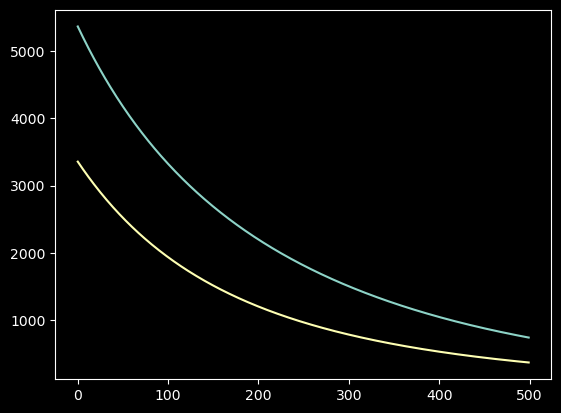

In [93]:
plt.plot(loss_progress, label='train')
plt.plot(test_loss, label='test')